In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import warnings
from imblearn.over_sampling import SMOTE

AttributeError: 'NoneType' object has no attribute 'split'

# Carregamento da base de dados e transformação das váriaveis

In [ ]:
warnings.filterwarnings("ignore") 

In [ ]:
planinha = pd.ExcelFile("Base_MUNIC_2021_20240425.xlsx")
planinha.sheet_names

In [ ]:
df = pd.read_excel("Base_MUNIC_2021_20240425.xlsx", sheet_name="Informações atual prefeito")
df

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
colunas_remover = ["CodMun", "Cod UF", 'Pop estimada 2021', 'Mpeg051']
df = df.drop(colunas_remover, axis=1)
df

In [ ]:
df.columns

In [ ]:
df.dtypes

In [ ]:
df = df.rename(columns={"Mpeg02": "Reeleito", "Mpeg03":"Sexo", "Mpeg04":"Idade", "Mpeg05":"Cor", "Mpeg06": "Escolaridade"})
df 

In [ ]:
df["Mun"] = df["Mun"].astype("string")
df["Faixa_pop"] = df["Faixa_pop"].astype("category")
df["Regiao"] = df["Regiao"].astype("category")
df["UF"] = df["UF"].astype("category")
df["Reeleito"] = df["Reeleito"].astype("category")
df["Sexo"] = df["Sexo"].astype("category")
df["Cor"] = df["Cor"].astype("category")
df["Escolaridade"] = df["Escolaridade"].astype("category")

In [ ]:
def tirar_texto(string):
    index = string.find("-") + 1
    return string[index:]

In [ ]:
df["Faixa_pop"] = df["Faixa_pop"].apply(tirar_texto)
df["Regiao"] = df["Regiao"].apply(tirar_texto)
df

In [ ]:
df['Escolaridade'].unique()

In [ ]:
df = df.replace("Não", "Nao")

In [ ]:
df = df.replace({"Não informou": None, "Recusa": None})
df = df[df["Idade"].notna()]

In [ ]:
df["Idade"] = df["Idade"].astype("int")

# Análise exploratória 

In [ ]:
df.groupby("Reeleito", observed=False)['UF'].count().plot(kind='bar', figsize=(8,4))

In [ ]:
df.groupby("Escolaridade", observed=False)['UF'].count().plot(kind='bar', figsize=(8,4))

In [ ]:
df.groupby("Faixa_pop", observed=False)['UF'].count().plot(kind='bar', figsize=(8,4))

In [ ]:
df1 = df.copy()
df1 = df1.drop(columns=['UF', 'Mun', 'Idade'])
colunas = df1.columns
colunas

In [ ]:
plt.figure(figsize=(18,8))
for i, col in enumerate(colunas, 1):
    if col == 'Reeleito':
        continue
    plt.subplot(4,3,i)
    agrupado = df1.groupby([col, "Reeleito"], observed=False).size().reset_index(name="Contagem")
    sns.barplot(y = col, x = 'Contagem', hue='Reeleito', data=agrupado, orient='h')
    plt.title(f'Contagem de candidatos por {col} e Reeleção')
    plt.ylabel(col)
    plt.xlabel('Contagem')
    plt.legend().remove()
    if i == len(colunas) - 1:
        handles, labels = plt.gca().get_legend_handles_labels()
plt.tight_layout()
plt.figlegend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
agrupado = df.groupby(["Regiao", "Cor"], observed=False).size().reset_index(name="Contagem")
agrupado

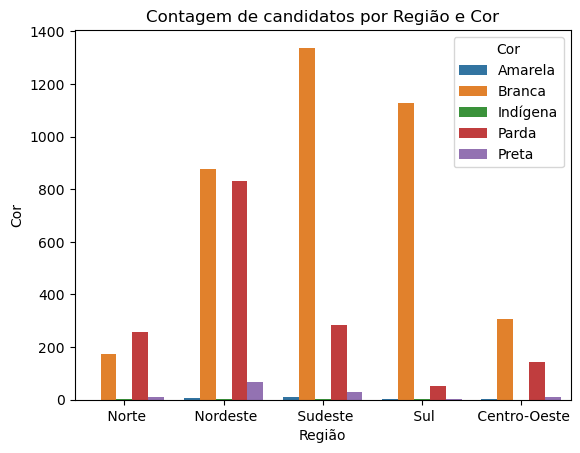

In [407]:
sns.barplot(x = 'Regiao', y = 'Contagem', hue='Cor', data=agrupado)
plt.title('Contagem de candidatos por Região e Cor')
plt.xlabel('Região')
plt.ylabel('Cor')

plt.show()

In [408]:
df["Idade"].describe()

count    5557.000000
mean       50.010077
std        10.867994
min        21.000000
25%        42.000000
50%        50.000000
75%        58.000000
max        95.000000
Name: Idade, dtype: float64

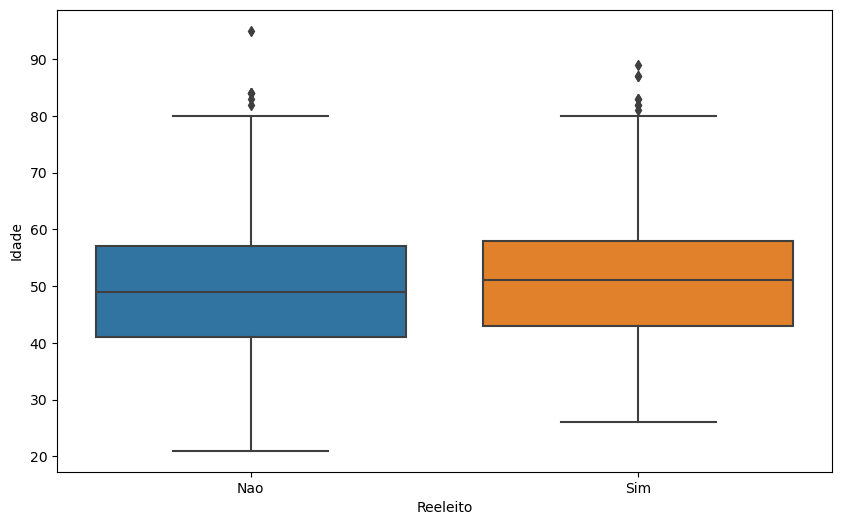

In [409]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Reeleito', y='Idade', data=df)
plt.show()

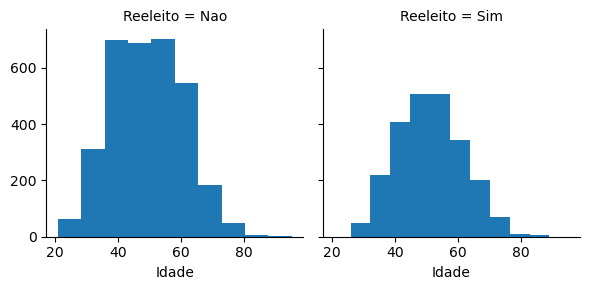

In [410]:
g = sns.FacetGrid(df, col='Reeleito')
g.map(plt.hist, 'Idade')
plt.show()

# Pre-processamento e escolha das váriaveis

In [411]:
df['Reeleito'] = df['Reeleito'].replace({'Sim': 1, 'Nao': 0})
df['Reeleito'] = df['Reeleito'].astype('bool')
df

,UF,Mun,Faixa_pop,Regiao,Reeleito,Sexo,Idade,Cor,Escolaridade
0,RO,Alta Floresta DOeste,20001 até 50000,Norte,False,Masculino,40,Branca,Especialização
1,RO,Ariquemes,100001 até 500000,Norte,False,Feminino,33,Branca,Ensino superior completo
2,RO,Cabixi,5001 até 10000,Norte,True,Masculino,50,Parda,Ensino superior completo
3,RO,Cacoal,50001 até 100000,Norte,False,Masculino,35,Parda,Ensino superior completo
4,RO,Cerejeiras,10001 até 20000,Norte,True,Feminino,57,Branca,Ensino superior completo
...,...,...,...,...,...,...,...,...,...
5565,GO,Vianópolis,10001 até 20000,Centro-Oeste,False,Masculino,38,Branca,Ensino superior completo
5566,GO,Vicentinópolis,5001 até 10000,Centro-Oeste,True,Masculino,55,Branca,Ensino médio (2º Grau) completo
5567,GO,Vila Boa,5001 até 10000,Centro-Oeste,False,Masculino,49,Branca,Ensino superior completo
5568,GO,Vila Propício,5001 até 10000,Centro-Oeste,False,Masculino,49,Parda,Ensino superior completo


Correlação entre as váriaveis independentes com a target váriavel usando o teste Chi-quadrado para as categóricas e t-student para a númerica.

In [412]:
categorical_vars = ['UF', 'Mun', 'Faixa_pop', 'Regiao', 'Sexo', 'Cor', 'Escolaridade']

for var in categorical_vars:
    tabela = pd.crosstab(df[var], df['Reeleito'])
    chi2, p, dof, expected = chi2_contingency(tabela)
    print(f"{var}: p-valor = {p:.5f}")

UF: p-valor = 0.31469
Mun: p-valor = 0.40540
Faixa_pop: p-valor = 0.01750
Regiao: p-valor = 0.65197
Sexo: p-valor = 0.00007
Cor: p-valor = 0.19880
Escolaridade: p-valor = 0.60785


In [413]:
numeric_vars = ['Idade']

for var in numeric_vars:
    grupo_0 = df[df['Reeleito'] == 0][var]
    grupo_1 = df[df['Reeleito'] == 1][var]
    t_stat, p_valor = ttest_ind(grupo_0, grupo_1, nan_policy='omit')
    print(f"{var}: p-valor = {p_valor:.5f}")

Idade: p-valor = 0.00000


In [414]:
y = df['Reeleito']
X = pd.get_dummies(df.drop(columns=['Reeleito', 'Mun', 'UF'], axis=1))

In [415]:
smotenc=SMOTE() 
X,y=smotenc.fit_resample(X,y)
y.value_counts()

Reeleito
False    3245
True     3245
Name: count, dtype: int64

# Modelo com Rede Neural Feedforward

In [416]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [417]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [418]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)), 
    layers.Dense(128, activation='relu'), 
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [419]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=early_stopping,
    verbose=1
)

Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4792 - auc: 0.4731 - loss: 0.7871 - precision: 0.4855 - recall: 0.4908 - val_accuracy: 0.4885 - val_auc: 0.5478 - val_loss: 0.7113 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5289 - auc: 0.5336 - loss: 0.7004 - precision: 0.5106 - recall: 0.4545 - val_accuracy: 0.5192 - val_auc: 0.5987 - val_loss: 0.7140 - val_precision: 0.5156 - val_recall: 0.9962
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5393 - auc: 0.5640 - loss: 0.6883 - precision: 0.5459 - recall: 0.5391 - val_accuracy: 0.5019 - val_auc: 0.6197 - val_loss: 0.6947 - val_precision: 0.8889 - val_recall: 0.0301
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5310 - auc: 0.5497 - loss: 0.7064 - precision: 0.5348 - recall: 0.4769 - val_accuracy: 0.5712 - val_auc: 0.6137 - val_loss: 0.6735 - val_precision: 0.5670 - val_recall: 0.6842
Epoch 5/100
146/146 

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5974 - auc: 0.6612 - loss: 0.6174 - precision: 0.6164 - recall: 0.5525 - val_accuracy: 0.5712 - val_auc: 0.6498 - val_loss: 0.6191 - val_precision: 0.5586 - val_recall: 0.7707
Epoch 60/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6113 - auc: 0.6821 - loss: 0.6094 - precision: 0.6145 - recall: 0.5834 - val_accuracy: 0.5692 - val_auc: 0.6445 - val_loss: 0.6419 - val_precision: 0.5471 - val_recall: 0.9173
Epoch 61/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5904 - auc: 0.6562 - loss: 0.6229 - precision: 0.5955 - recall: 0.5934 - val_accuracy: 0.6173 - val_auc: 0.6378 - val_loss: 0.6343 - val_precision: 0.9589 - val_recall: 0.2632


Acurácia: 0.6148
Precisão: 0.6447
Recall: 0.5008
AUC: 0.6582
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


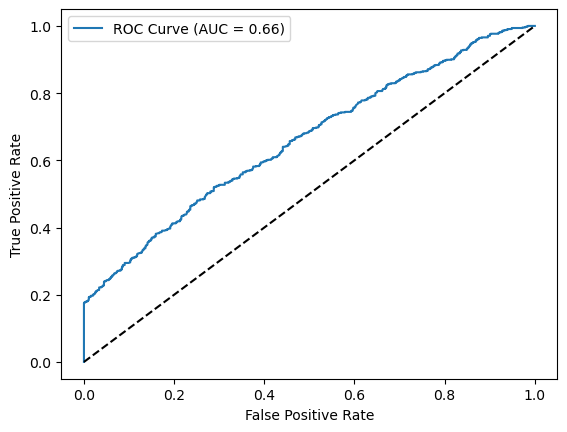

array([0.49659508, 0.39801037, 0.48545343, ..., 0.41260508, 0.42117903,
       0.37273115], dtype=float32)

In [420]:
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia: {results[1]:.4f}")
print(f"Precisão: {results[2]:.4f}")
print(f"Recall: {results[3]:.4f}")
print(f"AUC: {results[4]:.4f}")

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
y_pred_proba

# Tentativa com outros modelos

In [421]:
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'RBF Neural Network': MLPClassifier(hidden_layer_sizes=(50,), activation='tanh', solver='adam', max_iter=500, random_state=42),
    'BP Neural Network': MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=500, random_state=42)
}

In [422]:
desempenho = {}
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    desempenho[nome] = acc
    print(f'\nModelo: {nome}')
    print(f'Acurácia: {acc:.4f}')
    print(classification_report(y_test, y_pred))


Modelo: Random Forest
Acurácia: 0.5917
              precision    recall  f1-score   support

         0.0       0.60      0.58      0.59       653
         1.0       0.59      0.60      0.59       645

    accuracy                           0.59      1298
   macro avg       0.59      0.59      0.59      1298
weighted avg       0.59      0.59      0.59      1298


Modelo: SVM
Acurácia: 0.5308
              precision    recall  f1-score   support

         0.0       0.57      0.29      0.38       653
         1.0       0.52      0.78      0.62       645

    accuracy                           0.53      1298
   macro avg       0.54      0.53      0.50      1298
weighted avg       0.54      0.53      0.50      1298


Modelo: RBF Neural Network
Acurácia: 0.5971
              precision    recall  f1-score   support

         0.0       0.56      0.91      0.69       653
         1.0       0.75      0.28      0.41       645

    accuracy                           0.60      1298
   macro avg 

In [423]:
train_data = lgb.Dataset(X_train, label=y_train)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

model = lgb.train(params, train_data, num_boost_round=100)

[LightGBM] [Info] Number of positive: 2600, number of negative: 2592
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 117
[LightGBM] [Info] Number of data points in the train set: 5192, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500770 -> initscore=0.003082
[LightGBM] [Info] Start training from score 0.003082


In [424]:
y_pred = model.predict(X_test)
y_pred = [1 if p > 0.5 else 0 for p in y_pred]  
from sklearn.metrics import accuracy_score
print("Acurácia:", accuracy_score(y_test, y_pred))

Acurácia: 0.610939907550077
